In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import nltk
import math
import pickle

import xgboost
from collections import Counter


from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict

%matplotlib inline

In [2]:
# read in data from csv file
df = pd.read_csv('proteins-5-functions.csv')

df.head()

,classification,name,sequence,structureId,type
0,TRANSFERASE,NaN,MEIYEGKLTAEGLRFGIVASRFNHALVDRLVEGAIDCIVRHGGREE...,5MPP,4
1,HYDROLASE,NaN,MKFTLTIAGLLAVGSTAAPTTEKRNPGGIDYVQNYNGDVADFQYNE...,3M4F,0
2,TRANSFERASE,NaN,MRGSHHHHHHGSMKRAVITGLGIVSSIGNNQQEVLASLREGRSGIT...,2BYY,4
3,HYDROLASE,NaN,STGSATTTPIDSLDDAYITPVQIGTPAQTLNLDFDTGSSDLWVFSS...,4YCY,0
4,TRANSFERASE,NaN,GSGMMRYLHKIELELNRLTSRYPFFKKIAFDAEIIKLVDDLNVDEN...,3AQC,4


In [3]:
# read in more immune system sequences data from csv file
df_2 = pd.read_csv('uniprot-human-immune.csv')

df_2.head()

,name,sequence,classification,type
0,tr|Q6FGW4|Q6FGW4_HUMAN,MHSSALLCCLVLLTGVRASPGQGTQSENSCTHFPGNLPNMLRDLRD...,IMMUNE SYSTEM,1
1,tr|A0A024R5Z3|A0A024R5Z3_HUMAN,MSSILPFTPPIVKRLLGWKKGEQNGQEEKWCEKAVKSLVKKLKKTG...,IMMUNE SYSTEM,1
2,tr|A0A0B4Q6D0|A0A0B4Q6D0_9PLVG,MRVKGIRKNYQHLWRGGTLLLGMLMICSAVEKLWVTVYYGVPVWKE...,IMMUNE SYSTEM,1
3,tr|A0A0B4Q7W6|A0A0B4Q7W6_9PLVG,MRVKGIRKNYQHLWRGGTLLLGMLMICSAVEKLWVTVYYGVPVWKE...,IMMUNE SYSTEM,1
4,tr|A0A0B4Q6H6|A0A0B4Q6H6_9PLVG,MRVKGIRKNYQHLWRGGTLLLGMLMICSAVEKLWVTVHYGVPVWKE...,IMMUNE SYSTEM,1


In [4]:
df_2.shape

(84798, 4)

In [5]:
df3 = df_2.sample(frac=0.33)
df3.shape

(27983, 4)

In [6]:
df_hydro = pd.read_csv('uniprot-hydrolase-reviewed.csv')

df_hydro.head()

,name,sequence,classification,type
0,sp|P9WNH5|HSAD_MYCTU,MTATEELTFESTSRFAEVDVDGPLKLHYHEAGVGNDQTVVLLHGGG...,HYDROLASE,0
1,sp|P77044|MHPC_ECOLI,MSYQPQTEAATSRFLNVEEAGKTLRIHFNDCGQGDETVVLLHGSGP...,HYDROLASE,0
2,sp|Q75UV1|NDX1_THETH,MELGAGGVVFNAKREVLLLRDRMGFWVFPKGHPEPGESLEEAAVRE...,HYDROLASE,0
3,sp|Q60928|GGT1_MOUSE,MKNRFLVLGLVAVVLVFVIIGLCIWLPYTSGKPDHVYSRAAVATDA...,HYDROLASE,0
4,sp|P19440|GGT1_HUMAN,MKKKLVVLGLLAVVLVLVIVGLCLWLPSASKEPDNHVYTRAAVAAD...,HYDROLASE,0


In [7]:
df_h2 = df_hydro.sample(frac=0.45)
df_h2.shape

(26386, 4)

In [8]:
df_ox = pd.read_csv('uniprot-oxidoreductase-Feb1.csv')

df_ox.head()

,name,sequence,classification,type
0,sp|Q8L540|LTO1_ARATH,MMARFVSVSSCQFHFGFREVSPPSVTSYPRRFEVSDRRFPAIPIKC...,OXIDOREDUCTASE,5
1,sp|Q9AL95|NROR_CLOAB,MKSTKILILGAGPAGFSAAKAALGKCDDITMINSEKYLPYYRPRLN...,OXIDOREDUCTASE,5
2,sp|P55931|ETFD_PIG,MMVPLAKLASPAYQCFHALKIKKNYLPLCATRWSSTCKVPRITTHY...,OXIDOREDUCTASE,5
3,sp|Q16134|ETFD_HUMAN,MLVPLAKLSCLAYQCFHALKIKKNYLPLCATRWSSTSTVPRITTHY...,OXIDOREDUCTASE,5
4,sp|Q9NZC7|WWOX_HUMAN,MAALRYAGLDDTDSEDELPPGWEERTTKDGWVYYANHTEEKTQWEH...,OXIDOREDUCTASE,5


In [9]:
df_FeS = pd.read_csv('uniprot-ironSulfurCluster-Feb1.csv')

df_FeS.head()

,name,sequence,classification,type
0,tr|T0M7Z9|T0M7Z9_CAMFR,MAAVVAFSLRRRFPATTLGGACLQQPWLALQDSLARCVKPTGRDCK...,IRON-SULFUR-CLUSTER,6
1,tr|A0A1Q9C7M1|A0A1Q9C7M1_SYMMI,MSLAASLRSLAPRGLGRSGLRGFAAMAQPQTFAIYRYDPDQQAKPF...,IRON-SULFUR-CLUSTER,6
2,tr|A0A2P6TTG2|A0A2P6TTG2_CHLSO,MLSLIRQAGSLGQALCPELTQLVRTVASAAGAAGGASKPVVEKEFL...,IRON-SULFUR-CLUSTER,6
3,tr|A0A091CKG8|A0A091CKG8_FUKDA,MAAVAGFSLRRRFPATVLGGSCLQACRGAQTAADRAPRIKKFAIYR...,IRON-SULFUR-CLUSTER,6
4,tr|Q59QN7|Q59QN7_CANAL,MFRSILHQQKAVQFSVRSLATAAAEKAPRLKKFQIYRWNPDTPEVQ...,IRON-SULFUR-CLUSTER,6


In [10]:
df_gpcr = pd.read_csv('uniprot-gpcr-unreviewed.csv')

df_gpcr.head()

,name,sequence,classification,type
0,tr|G3V654|G3V654_RAT,MAATTPAQDVGVEIYLGPVWPAPSNSTPLALNLSLALREDAPGNLT...,GPCR,8
1,tr|A0A287DFW8|A0A287DFW8_ICTTR,MDVTSPAHTFGMEIYPRTTQLADSNSTSPELNLSLPLQGTALVNQT...,GPCR,8
2,tr|A0A0R4J0N8|A0A0R4J0N8_MOUSE,MEPISVSIYTSDNYSEEVGSGDYDSNKEPCFRDENVHFNRIFLPTI...,GPCR,8
3,tr|A0A1U7QAF5|A0A1U7QAF5_MESAU,MDPLNLSWYDDDLERQNWSRPFNGSEGKADRPHYNYYAMLLTLLIF...,GPCR,8
4,tr|A0A0N8ETT2|A0A0N8ETT2_HETGA,MDPLNLTWYDDDLERQNWSRSFNGSEGKADRPHYNYYAMLLTLLIF...,GPCR,8


In [11]:
df_gp2 = df_gpcr.sample(frac=0.16)

df_gp2.shape

(31401, 4)

In [12]:
df_lb = pd.read_csv('uniprot-lipidBinding-Feb5.csv')
df_lb2 = df_lb.sample(frac=0.5)

df_lb2.shape

(31304, 4)

In [13]:
df_tr = pd.read_csv('uniprot-transport-Feb6.csv')
df_tr2 = df_tr.sample(frac=0.75)

df_tr2.shape

(47019, 4)

In [14]:
df_abc = pd.read_csv('uniprot-ABC-Feb8.csv')

df_abc.shape

(3642, 4)

In [15]:
df_dna = pd.read_csv('uniprot-DNA-Binding-Feb8.csv')

df_dna.shape

(60440, 4)

In [16]:
df.columns

Index([u'classification', u'name', u'sequence', u'structureId', u'type'], dtype='object')

In [17]:
df.shape

(104956, 5)

In [18]:
# concat the dataframes
df_ = pd.concat([df,df3,df_h2,df_ox,df_FeS,df_gp2,df_lb2,df_tr2,df_abc,df_dna])

df_.head()

/Users/scottlew/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,classification,name,sequence,structureId,type
0,TRANSFERASE,NaN,MEIYEGKLTAEGLRFGIVASRFNHALVDRLVEGAIDCIVRHGGREE...,5MPP,4
1,HYDROLASE,NaN,MKFTLTIAGLLAVGSTAAPTTEKRNPGGIDYVQNYNGDVADFQYNE...,3M4F,0
2,TRANSFERASE,NaN,MRGSHHHHHHGSMKRAVITGLGIVSSIGNNQQEVLASLREGRSGIT...,2BYY,4
3,HYDROLASE,NaN,STGSATTTPIDSLDDAYITPVQIGTPAQTLNLDFDTGSSDLWVFSS...,4YCY,0
4,TRANSFERASE,NaN,GSGMMRYLHKIELELNRLTSRYPFFKKIAFDAEIIKLVDDLNVDEN...,3AQC,4


In [19]:
df_.shape

(404127, 5)

In [20]:
# drop 'old' function/type column
#df.drop(columns=['type'])

In [21]:
# use label encoder to create new numbers for each function
le = preprocessing.LabelEncoder()
le.fit(df.classification)
df['type'] = le.transform(df['classification'])

## Remove duplicate protein sequences from data

In [22]:
# remove the duplicate protein sequences
df_ = df_.drop_duplicates(subset='sequence', keep="first")

df_.shape

(380099, 5)

In [23]:
# remove non-coding amino acid letters like X,B,U
df_['sequence'] = df_['sequence'].str.replace('U','G')
df_['sequence'] = df_['sequence'].str.replace('X','G')
df_['sequence'] = df_['sequence'].str.replace('B','G')

## 11 Classes of Proteins

In [24]:
df_.classification.value_counts()

DNA BINDING            52990
TRANSPORT              38104
OXIDOREDUCTASE         37545
HYDROLASE              37417
TRANSFERASE            35880
LIGASE                 33967
IMMUNE SYSTEM          33435
GPCR                   31398
LIPID BINDING          31190
IRON-SULFUR-CLUSTER    31185
ISOMERASE              16988
Name: classification, dtype: int64

In [25]:
df_.type.value_counts()

12    52990
10    38104
5     37545
0     37417
4     35880
3     33967
1     33435
8     31398
9     31190
6     31185
2     16988
Name: type, dtype: int64

In [26]:
def peptide_counter(sequences,peptide_size):
    ''' This function returns the count of peptide of user defined size in a sequence'''
    # instantiate a CountVectorizer()
    vector = CountVectorizer(min_df=1,token_pattern=r'\w{1}',ngram_range=(peptide_size,peptide_size))
    
    # transform the protein sequences 
    X = vector.fit_transform(sequences)
    
    vocab = list(vector.get_feature_names())
    vocab = [str(aa) for aa in vocab]
    counts = X.sum(axis=0).A1
    
    return Counter(dict(zip(vocab, counts)))
    

## Counter of Peptides, Pentapeptides, for ALL protein sequences in the dataset

In [27]:
sequences_all = df_.sequence

peptide_size = 5

peptide_all_counter = peptide_counter(sequences_all,peptide_size)

peptide_all_counter.most_common(10)

[('g g g g g', 46693),
 ('l l l n g', 17557),
 ('l l n g s', 17450),
 ('l t v w g', 17379),
 ('y g v p v', 17338),
 ('g v p v w', 17319),
 ('l f c a s', 17312),
 ('g i v q q', 17293),
 ('c t h g i', 17283),
 ('i v q q q', 17282)]

In [28]:
peptide_Top = peptide_all_counter.most_common(10)
#print(type(DNA_Top))

for item in peptide_Top:
    print(item)

('g g g g g', 46693)
('l l l n g', 17557)
('l l n g s', 17450)
('l t v w g', 17379)
('y g v p v', 17338)
('g v p v w', 17319)
('l f c a s', 17312)
('g i v q q', 17293)
('c t h g i', 17283)
('i v q q q', 17282)


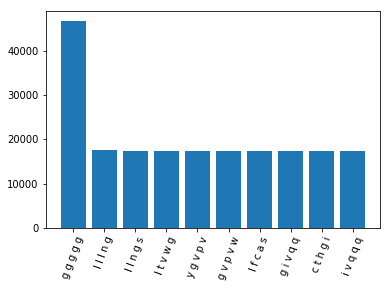

In [29]:
plt.bar(range(len(peptide_Top)), [tup[1] for tup in peptide_Top], align='center')
plt.xticks(range(len(peptide_Top)), [tup[0] for tup in peptide_Top])
plt.xticks(rotation=70)
plt.show()

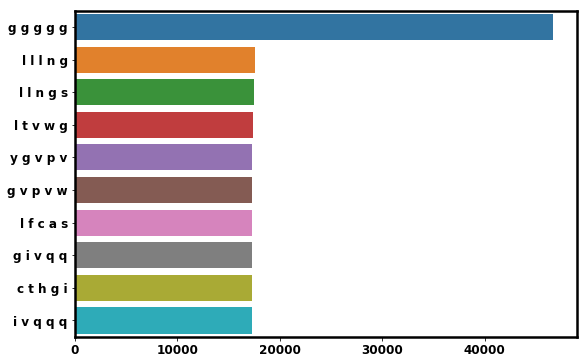

In [30]:
fig, ax = plt.subplots(figsize=(9, 6))
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
sns.barplot(x = [tup[1] for tup in peptide_Top],y= [tup[0] for tup in peptide_Top])
plt.xticks(fontsize=12,fontweight='bold')
plt.yticks(fontsize=12,fontweight='bold')
plt.savefig('pentapeptides_functions_ALL.png')
